### *Library*

---



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout,\
                       BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import load_model
from keras.models import load_model

%matplotlib inline

###  **Временные ряды**, *модель для прогнозирования трафика сайта*.


---




In [ ]:
traff = pd.read_csv('/content/drive/My Drive/Базы/traff.csv')
traff.head(3)

,1/1/2017,"22,226.00"
0,1/2/2017,"29,593.00"
1,1/3/2017,"31,726.00"
2,1/4/2017,"32,684.00"


In [ ]:
def pars(arg):
  c1 = arg.split('.')
  c1 = c1[0].replace(',','.')
  return c1
traff.rename(columns={'1/1/2017': 'Date', '22,226.00':'Traffic'}, inplace=True)
traff.iloc[:,1] = [pars(i) for i in traff.iloc[:,1]]
traff = traff.astype({'Traffic':float})

In [ ]:
traff = traff.iloc[:,1]
traff

0       29.593
1       31.726
2       32.684
3       31.820
4       29.354
         ...  
1089    29.801
1090    34.913
1091    37.665
1092    32.643
1093    28.212
Name: Traffic, Length: 1094, dtype: float64

In [ ]:
tr = np.array(traff)

In [ ]:
print(tr.shape)
print(tr[0])

(1094,)
29.593


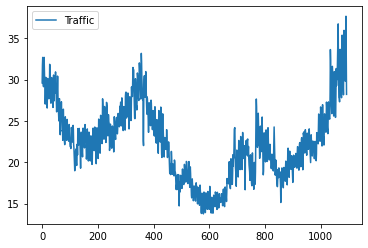

In [ ]:
plt.plot(tr, label='Traffic')
plt.legend()
plt.show()

#### *Функция загрузки данных*

---



In [ ]:
xLen = 60
valLen = 194
trainLen = tr.shape[0]-valLen
xTrain, xTest = np.reshape(tr[:trainLen], (-1,1)),  np.reshape(tr[trainLen+xLen+2:], (-1,1))
yTrain, yTest = np.reshape(tr[:trainLen], (-1,1)), np.reshape(tr[trainLen+xLen+2:], (-1,1))
#Нормируем данные
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

# Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen, stride=1,
                                   batch_size=20)
# Создаем генератор для проверки
testDataGen = TimeseriesGenerator(xTest, yTest, length=xLen, stride=1,
                                  batch_size=20)                                

Epoch 1/30
42/42 [==============================] - 2s 51ms/step - loss: 0.0456 - val_loss: 0.0404
Epoch 2/30
42/42 [==============================] - 2s 47ms/step - loss: 0.0097 - val_loss: 0.0352
Epoch 3/30
42/42 [==============================] - 2s 47ms/step - loss: 0.0081 - val_loss: 0.0268
Epoch 4/30
42/42 [==============================] - 2s 47ms/step - loss: 0.0067 - val_loss: 0.0252
Epoch 5/30
42/42 [==============================] - 2s 47ms/step - loss: 0.0069 - val_loss: 0.0145
Epoch 6/30
42/42 [==============================] - 2s 47ms/step - loss: 0.0048 - val_loss: 0.0153
Epoch 7/30
42/42 [==============================] - 2s 47ms/step - loss: 0.0051 - val_loss: 0.0122
Epoch 8/30
42/42 [==============================] - 2s 47ms/step - loss: 0.0047 - val_loss: 0.0102
Epoch 9/30
42/42 [==============================] - 2s 46ms/step - loss: 0.0047 - val_loss: 0.0291
Epoch 10/30
42/42 [==============================] - 2s 47ms/step - loss: 0.0051 - val_loss: 0.0112
Epoch 11/

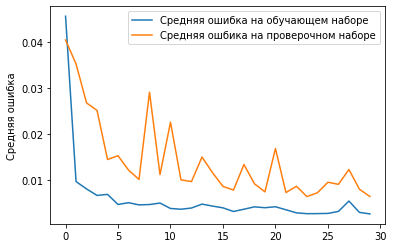

In [ ]:
model_D = Sequential()
model_D.add(Dense(128, input_shape = (xLen, 1), activation='linear'))
model_D.add(Dense(256, input_shape = (xLen, 1), activation='linear'))
model_D.add(Dense(512, input_shape = (xLen, 1), activation='linear'))
model_D.add(Dense(256, input_shape = (xLen, 1), activation='linear'))
model_D.add(Flatten())
model_D.add(Dense(1, activation='linear'))
model_D.compile(loss='mse', optimizer=Adam(0.0001))
hist = model_D.fit_generator(trainDataGen, epochs=30, verbose=1,\
                           validation_data=testDataGen)

plt.plot(hist.history['loss'],
         label='Средняя ошибка на обучающем наборе')
plt.plot(hist.history['val_loss'],
         label='Средняя ошбика на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
for i in range(10):
  y1 = yScaler.inverse_transform(yVal[0][i].reshape(-1,1))
  y2 = yScaler.inverse_transform(model_D.predict(xVal[0][i].reshape(1,60, 1)))
  x01 = str(round(y1[0][0], 3))
  x02 = str(round(y2[0][0], 2))
  print('Реальное: ', x01,' ' * (15-len(x01)), 'Предсказанное:', x02)

Реальное:  26.631           Предсказанное: 26.49
Реальное:  25.371           Предсказанное: 25.34
Реальное:  24.206           Предсказанное: 24.66
Реальное:  23.912           Предсказанное: 23.48
Реальное:  23.454           Предсказанное: 23.25
Реальное:  25.13            Предсказанное: 24.4
Реальное:  27.298           Предсказанное: 26.37
Реальное:  26.644           Предсказанное: 26.31
Реальное:  26.341           Предсказанное: 25.23
Реальное:  25.357           Предсказанное: 25.11


#### Функции визуализации результатов

---



In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)

  return (predVal, yValUnscaled)

def showPredict(start, step, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, 0],
           label='Базовый ряд')
  plt.legend()
  plt.show()

def correlete(a,b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

def showCorr(corrSteps, predVal, yValUnscaled):
  corr = []
  yLen = yValUnscaled.shape[0]

  for i in range(corrSteps):
    corr.append(correlate(yValUnscaled[:yLen-i, 0], predVal[i:, 0]))
  own_corr = []
  for i in range(corrSteps):
    own_corr.append(correlate(yValUnscaled[:yLen-i, 0], yValUnscaled[i:,0]))
  plt.plot(corr, label='Предсказание')
  plt.plot(own_corr, label = 'Эталон')

  plt.legend()
  plt.show()

In [ ]:
DataGen = TimeseriesGenerator(xTest, yTest, length=60,\
                              stride=1, batch_size = len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])
xVal = np.array(xVal)
yVal = np.array(yVal)

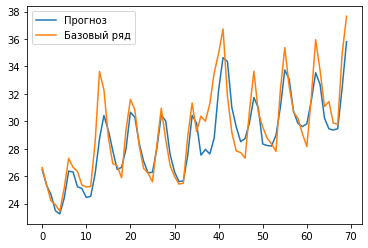

In [ ]:
currModel = model_D 
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)
showPredict(0, 70, predVal, yValUnscaled)

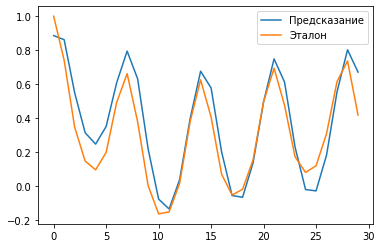

In [ ]:
showCorr(30, predVal, yValUnscaled)